In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import deque

# The following defined function shiftDetect() is able to :
# 1. Detect if mean or var shifts for continous stream data
Use Hawkins CUSUM Method described in http://rmgsc.cr.usgs.gov/outgoing/threshold_articles/Hawkins_Zamba2005b.pdf
and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
Tunable Parameters:
k : Allowance value, a threshold that signals a possible shift starts at the current position
H : If CUSUM value goes beyond this value, conclude a shift has occured and the shift starts at the last point
whose CUSUM is larger than k Allowance value
Seperate k and H values are used for mean and var shift detection

# 2. Detect concept change for attributes stream data
Function to get detect concept change for attributes data
Assign char a,b,c to uniformly distributed value seperately for all data points first
Then, group data samples into sub group first,with each group has n data points,calculate the average of each subgroup
Therefore we get a new continous data array named sample
Plot the sample and a shift can be seen obviously
To-do: Experiment using p chart, or Shewart chart or CUSUM or other methods to detect the change position
and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
Tunable Parameters:
n : subgroup sample size n 
t: The first t data points be selected as baseline
posTriple2_160,posTriple_175, posTripleDouble_175, negTriple,negWithRare,negBinary Verified

# Usage example
with open('posShiftUpVar_70.txt') as f: # Open file as f
    lines = f.read().splitlines()  # Split file line by line and put lines in to var "lines"
f.close() # Close file
try:
    data = [float(i) for i in lines] # For variable dataa stream,convert data string to float if convertable
except: 
    data = lines # Otherwise for attribute data, no convert needed     
shiftDetect(data)

In [2]:
def SlideWindow(data):
    winSize = 20
    winA = data[:winSize]
    winB = data[winSize+1:2*winSize +1]
    print(winA, winB)
    i = 1

    while 2*winSize+1+i < len(data):
        if np.mean(winA) <  np.mean(winB) and (winSize + i > 50): ## Assume change occurs only after 50 points
            if abs(np.mean(winA) - np.mean(winB)) >= 0.25*(np.mean(winA)): ## 0.5, 0.23

                print ("Mean change gets larger at position " + str(winSize + i))
                print(np.mean(winA),np.mean(winB))
                return winSize + i
        if np.mean(winA) >  np.mean(winB):
            if abs(np.mean(winA) - np.mean(winB)) >= 0.4*(np.mean(winA)):

                print ("Mean change gets smaller at position " + str(winSize + i))
                print(np.mean(winA),np.mean(winB))
                return winSize + i
            
        if np.var(winB) > np.var(winA):
            if abs(np.var(winA) - np.var(winB)) >= 9*(np.var(winA)): ## 12
                print ("Variance changes to larger occured at position " + str(winSize + i))
                print(np.var(winA),np.var(winB))
                return winSize + i
        
        if np.var(winB) < np.var(winA):
            if abs(np.var(winA) - np.var(winB)) >= 0.8*(np.var(winA)):
                print ("Variance changes to smaller occured at position " + str(winSize + i))
                print(np.var(winA),np.var(winB))
                return winSize + i
    

        winA = deque(winA)
        winB = deque(winB)
        winA.popleft()
        winA.append(winB.popleft())
        winB.append(data[2*winSize + 1 + i])
        i = 1 + i

    print ("no change")
    return -1
    

In [43]:
#### Use Hawkins CUSUM Method described in http://rmgsc.cr.usgs.gov/outgoing/threshold_articles/Hawkins_Zamba2005b.pdf
#### and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
#### Tunable Parameters:
#### k : Allowance value, a threshold that signals a possible shift starts at the current position
#### H : If CUSUM value goes beyond this value, conclude a shift has occured and the shift starts at the last point
####  whose CUSUM is larger than k Allowance value
#### Seperate k and H values are used for mean and var shift detection
#### Usage example: data = np.loadtxt("posShiftUpVar_70.txt", delimiter=",") shiftDetect(data)

def CUSUMDetect(data):
    
    cusums_mean_up = []   # Ci array for mean upper shift detection
    N_mean_up = [] # N+ array for mean upper shift detection
    n_mean_up = 0 # N1 = 0
    cusum_mean_up = 0   # C1 = 0 for mean upper shift detection
    cusums_mean_lo = []   # Ci array for mean lower shift detection
    N_mean_lo = [] # N+ array for mean lower shift detection
    n_mean_lo = 0 # N1 = 0
    cusum_mean_lo = 0   # C1 = 0 for mean lower shift detection
    
    cusums_var_up = [] # Ci array for var upper shift detection
    N_var_up = [] # N+ arrary for var upper shift detection
    n_var_up = 0 # N1 = 0
    cusum_var_up = 0 # C1 = 0 for var upper shift detection
    cusums_var_lo = [] # Ci array for var lower shift detection
    N_var_lo = [] # N+ arrary for var lower shift detection
    n_var_lo = 0 # N1 = 0
    cusum_var_lo = 0 # C1 = 0 for var lower shift detection
    
    n = 50 # The first n samples form the baseline
    i = 1 # The index looping through
    mean = np.mean(data[:n]) # mean of baseline
    sd = np.std(data[:n]) # std of baseline
    k = 2 * sd  # Allowance value for mean shift detection
    H = 12 * sd # Decision interval for mean shift detection
    k_v = 1 * sd # Allowance value for var shift detection
    if mean/sd <= 2:
        H_v = 1.5 * mean/sd * sd # Decision interval for var shift detection that mean and std are close
    else:
        H_v = 5* mean/sd *sd # Decision interval for var shift detection that std is much smaller than mean
    #print ("mean of 50 samples = " + str(mean))
    #print ("std of 50 samples = " + str(sd))
    #print ("Allowance value of mean = " + str(k))
    #print ("Decision interval of mean = " + str(H))
    #print ("Allowance value of variance = " + str(k_v))
    #print ("Decision interval of variance = " + str(H_v))
    
   
    
    #for x in data[n+1:]: # Start building CUSUM tabular from the n+1 point
    for x in data: # Start building CUSUM tabular 
        
        ## Tabular CUSUM for mean shift detection
        # mean upper shift CUSUM tabular generation
        cusum_mean_up = max(0, x - (mean + k) + cusum_mean_up) # Ci = max(0, xi-(mean+k)+Ci-1) for mean shift detection
        
        if cusum_mean_up == 0: # if cusum value is 0 
             n_mean_up = 0    # not start recording a possible shift change, set index Number to 0
        else:
             n_mean_up = n_mean_up + 1 # else if cusum value is not 0 
        N_mean_up.append(n_mean_up) # start recording a possible shift change, increment index Number by 1
            
        cusums_mean_up.append(cusum_mean_up) # Append CUSUM
        
        # mean lower shift CUSUM tabular generation
        cusum_mean_lo = max(0, (mean - k) - x + cusum_mean_lo) # Ci = max(0, (mean-k)-xi+Ci-1) for mean shift detection
        
        if cusum_mean_lo == 0: # if cusum value is 0 
             n_mean_lo = 0     # not start recording a possible shift change, set index Number to 0
        else:
             n_mean_lo = n_mean_lo + 1 # else if cusum value is not 0 
        N_mean_lo.append(n_mean_lo)   # start recording a possible shift change, increment index Number by 1
             
        cusums_mean_lo.append(cusum_mean_lo) # Append CUSUM 
        
        ## Tabular CUSUM for var shift detection
        ## Ci  for var shift detection,Hawkins metod: yi = (xi - mean)/std, vi = (sqrt(abs(yi)) - 0.822)/0.349
        ## Si+ = max(0,vi-k+Si-1) , Si- = max(0,-k-vi+Si-1)
        
        # var upper shift CUSUM tabular generation
        y = (x - mean)/sd
        if mean/sd <= 2:
           v = ((np.sqrt(abs(y))) - 0.822) / 0.01 # v for mean and std are very close like posVarup 60 file
        else:
           v = ((np.sqrt(abs(y))) - 0.822) / 0.03  #file for std is much smaller than mean like posVarup70 file
        
        cusum_var_up = max(0, v - k_v + cusum_var_up)
        
        if cusum_var_up == 0: # if cusum value is 0 
             n_var_up = 0     # not start recording a possible shift change, set index Number to 0
        else:
             n_var_up = n_var_up + 1 # else if cusum value is not 0 
        N_var_up.append(n_var_up)   # start recording a possible shift change, increment index Number by 1
        
        cusums_var_up.append(cusum_var_up) # Append CUSUM 
        
        # var lower shift CUSUM tabular generation
        # cusum_var_lo = max(0,-v - k_v + cusum_var_up)
        cusum_var_lo = abs(-v - k_v + cusum_var_up)
        
        if cusum_var_lo == 0: # if cusum value is 0 
             n_var_lo = 0     # not start recording a possible shift change, set index Number to 0
        else:
             n_var_lo = n_var_lo + 1 # else if cusum value is not 0 
        N_var_lo.append(n_var_lo)   # start recording a possible shift change, increment index Number by 1
        
        cusums_var_lo.append(cusum_var_lo) # Append CUSUM 
        
        
        i = i + 1
        ## Decide if shift in mean or var is detected
        if cusum_mean_up > H:
           
            c_i = i - (n_mean_up - 1) # The position where change right starts
            print("Mean shifted up at position " + str(c_i))
            
            #print("CUSUM = " + str(cusums_mean_up))
            plt.plot(cusums_mean_up)
            plt.title("CUSUM of MEAN UP " + str(c_i) + " observations")
            plt.show()
            return c_i
        
        if cusum_mean_lo > H:
            
            c_i = i - (n_mean_lo - 1) # The position where change right starts
            print("Mean shifted down at position " + str(c_i))
            #print("CUSUM = " + str(cusums_mean_lo))
            plt.plot(cusums_mean_lo)
            plt.title("CUSUM of MEAN DOWN" + str(c_i) + " observations")
            plt.show()
            return c_i
        
        
        if cusum_var_up > H_v:
            #c_i = i + n + 1 - (n_var_up - 1) # The position where change right starts
            c_i = i  - (n_var_up - 1)
            print("Variance shifted up at position " + str(c_i))
            #print("CUSUM = " + str(cusums_var_up))
            plt.plot(cusums_var_up)
            plt.title("CUSUM of VAR up" + str(c_i) + " observations")
            plt.show()
            return c_i
        
        if cusum_var_lo > H_v:
            #c_i = i + n + 1 - (n_var_lo - 1) # The position where change right starts
            c_i = i  - (n_var_lo - 1)
            print("Variance shifted down at position " + str(c_i))
            #print("CUSUM = " + str(cusums_var_lo))
            plt.plot(cusums_var_lo)
            plt.title("CUSUM of VAR down" + str(c_i) + " observations")
            plt.show()
            return c_i
        
       
    print("No Change detected using CUSUM method")
    #plt.plot(data)
    #plt.title("All Data Points")
    #plt.show()
    
    #print("CUSUM = " + str(cusums_mean_up))
    #plt.plot(cusums_mean_up)
    #plt.title("CUSUM of mean up")
    #plt.show()
    
    #print("CUSUM = " + str(cusums_mean_lo))
    #plt.plot(cusums_mean_lo)
    #plt.title("CUSUM of mean down")
    #plt.show()
    
    #print("CUSUM = " + str(cusums_var_up))
    #plt.plot(cusums_var_lo)
    #plt.title("CUSUM of VAR up")
    #plt.show()
    
    #print("CUSUM = " + str(cusums_var_lo))
    #plt.plot(cusums_var_lo)
    #plt.title("CUSUM of VAR down")
    #plt.show()
    #plt.plot(all_cusums)
    #plt.title("CUSUM of " + str(n) + " observations")
    #plt.show()
    return -1

In [4]:
#### Function to get detect concept change for attributes data
#### Assign char a,b,c to uniformly distributed value seperately for all data points first
#### Then, group data samples into sub group first,with each group has n data points,calculate the average of each subgroup
#### Therefore we get a new continous data array named sample
#### Plot the sample and a shift can be seen obviously
#### To-do: Experiment using p chart, or Shewart chart or CUSUM or other methods to detect the change position
#### and in Douglas C. Montgomery Statistical Quality Control 6th Edition Page 400-Page 417 Chapter Time-Weighted Control Charts
#### Tunable Parameters:
#### n : subgroup sample size n 
#### t: The first t data points be selected as baseline
## posTriple2_160,posTriple_175, posTripleDouble_175, negTriple,negWithRare,negBinary Verified

def AttrToCont(lines):
    
    np.random.seed(123456789)

    data = [] # Initiate an array "data" to hold original attributes data 
    for x in lines:
        if x == 'a':    #  # Convert char a to a random number from 0 to 1 and append to data array
            #data.append(0) 
            data.append(np.random.uniform(0,1,1))
        if x == 'b':     # Convert char b to a random number from 1 to 2 and append to data array
            #data.append(1)
            data.append(np.random.uniform(1,2,1))
        if x == 'c':    # Convert char c to a random number from 2 to 3 and append to data array
            #data.append(2)
            data.append(np.random.uniform(2,3,1))
        

    n = 14 # Tunable parameter to group each n+1 data points into a new sample point
    m = len(data)/(n+1) # Number of samples converted from original data
    sample = [] # A new array to hold continous data converted from attributes data

    ## Fill in the new sample data array converted from original attributes data
    for i in range(int(m)):
        if i == 0:
            sample.append(sum(data[:n])/(n+1))   # Append the average values of each n+1 data points
        else:
            sample.append(sum(data[i*n+1:(i+1)*n])/(n+1))  # Append the average values of each n+1 data points

    #print("Converted variable values are" + str(sample))
    
    return sample

In [40]:
def shewartDetect(sample,s):

    t = 4 # Choose the first t+1 numbers of sample points as baseline

    ## Calculate control limits using P chart method
    mean = np.average(sample[:t]) # Get the mean of baseline data
    sd = np.std(sample[:t])
    #UCL = mean + 3*np.sqrt(mean*(1-mean)/(n+1)) # Upper control limit in P chart, does not work for negtriple, tripledouble
    #LCL = mean - 3*np.sqrt(mean*(1-mean)/(n+1)) # Lower control limit in P chart,does not work for negtriple, tripledouble
    UCL = mean + 4*sd # Upper control limit in Shewart method
    LCL = mean - 3*sd # Lower control limit in Shewart method
    UWL = mean + 2*sd # Upper control limit in Shewart method
    LWL = mean - 2*sd # Lower control limit in Shewart method

    #print("mean is in Shewart method:" + str(mean)) # Print the mean value of the control chart
    #print("UCL is in Shewart method: " + str(UCL))  # Print the UCL value of the control chart
    #print("LCL is in Shewart method: " + str(LCL))  # Print the LCL value of the control chart
    #print("UWL is in Shewart method: " + str(UWL))  # Print the UCL value of the warning chart
    #print("LWL is in Shewart method: " + str(LWL))  # Print the LCL value of the warning chart
  
    
    #N = [] # Array to record outside threhold points index in a trend
    n = 0 # index starts from 0 which means not a point outsidte control threshold
    m = 0 # index starts from 0 which means not a point outsidte warning threshold
    ## Detect if there is concept change occurs after the baseline sample points
    for i in range(t+1,len(sample)):
        if (sample[i] >= UCL) | (sample[i] <= LCL): # If there is a point outside threshold
            n = n + 1
            #N.append(n)
            if n == 3: # If it is the consecutive 3rd point that is outside threshold
                
                #print("That corresponds to the "+str(i-2)+"th position on the converted data graph below")
                #print("The change occur sample value is"+str(sample[i-3]))
                plt.plot(sample) # Plot the converted variable smaple data 
                plt.plot([0, len(sample)], [UCL, UCL], 'r--', color='r')  # Plot the Upper Control Limit
                plt.plot([0, len(sample)], [LCL, LCL], 'r--', color='r') # Plot the Lower Control LIMIT
                plt.text(1, UCL - 0.05, 'UCL',color='r') # Label out UCL 
                plt.text(1, LCL + 0.05, 'LCL',color='r') # Label out LCL 
                plt.plot([0, len(sample)], [UWL, UWL], 'r--', color='r')  # Plot the Upper Warning Limit
                plt.plot([0, len(sample)], [LWL, LWL], 'r--', color='r') # Plot the Lower Warning LIMIT
                plt.text(1, UWL - 0.05, 'UWL',color='r') # Label out UWL 
                plt.text(1, LWL + 0.05, 'LWL',color='r') # Label out LWL 
                plt.title("Change Ocurred because 3 consective points outsidte UCL OR LCL")
                plt.show()
                if s == True:
                    print("Concept change occured at position " + str((i-3)*(n+1)*3) + "of original attributes data")
                    return (i - 3)*(n+1)*3
                elif s == False:
                    print("Concept change occured at position " + str(i-3))
                    return i - 3
        elif (sample[i] >= UWL) | (sample[i] <= LWL): # If there is a point outside warning threshold:
            m = m + 1
            if m == 5: # If it is the consecutive 3rd point that is outside threshold
                
                #print("That corresponds to the "+str(i-2)+"th position on the converted data graph below")
                #print("The change occur sample value is"+str(sample[i-4]))
                plt.plot(sample) # Plot the converted variable smaple data 
                plt.plot([0, len(sample)], [UCL, UCL], 'r--', color='r')  # Plot the Upper Control Limit
                plt.plot([0, len(sample)], [LCL, LCL], 'r--', color='r') # Plot the Lower Control LIMIT
                plt.text(1, UCL - 0.05, 'UCL',color='r') # Label out UCL 
                plt.text(1, LCL + 0.05, 'LCL',color='r') # Label out LCL
                plt.plot([0, len(sample)], [UWL, UWL], 'r--', color='r')  # Plot the Upper Warning Limit
                plt.plot([0, len(sample)], [LWL, LWL], 'r--', color='r') # Plot the Lower Warning LIMIT
                plt.text(1, UWL - 0.05, 'UWL',color='r') # Label out UWL 
                plt.text(1, LWL + 0.05, 'LWL',color='r') # Label out LWL 
                plt.title("Change Ocurred because 5 consecutive points outside UWL OR LWL")
                plt.show()
                if s == True:
                    print("Concept change occured at position " + str((i-4)*(n+1)*3) + "of original attributes data")
                    return (i - 4)*(n+1)*3
                elif s == False:
                    print("Concept change occured at position " + str(i-4))
                    return i - 4
               
        else:
            n = 0
            m = 0
    
         
    
    print("No Change detected using Shewart method")
    plt.plot(sample) # Plot the converted variable smaple data 
    plt.plot([0, len(sample)], [UCL, UCL], 'r--', color='r')  # Plot the Upper Control Limit
    plt.plot([0, len(sample)], [LCL, LCL], 'r--', color='r') # Plot the Lower Control LIMIT
    plt.text(1, UCL - 0.05, 'UCL',color='r') # Label out UCL 
    plt.text(1, LCL + 0.05, 'LCL',color='r') # Label out LCL 
    plt.plot([0, len(sample)], [UWL, UWL], 'r--', color='r')  # Plot the Upper Control Limit
    plt.plot([0, len(sample)], [LWL, LWL], 'r--', color='r') # Plot the Lower Control LIMIT
    plt.text(1, UWL - 0.05, 'UWL',color='r') # Label out UCL 
    plt.text(1, LWL + 0.05, 'LWL',color='r') # Label out LCL 
    plt.title("Converted Variable Plot from Original Attributes Data")
    plt.show()

    return -1

In [42]:
#### Use Kolmogorov-Smirnov Test described in http://www.physics.csbsju.edu/stats/KS-test.html
#### Tunable Parameters:
#### a : Significant level (0.05 or 0.01) to reject the null hypothesis that there is no change (default is 0.01)
#### w_size : Window size (default is 15 observations)
#### Usage example: data = np.loadtxt("posShiftUpMean_70.txt", delimiter=",") KSDetect(data)

def KSdetect(data, w_size=15, a=0.01):

    # loop to detect change
    for i in range(len(data)):
        if i - w_size >= w_size:
            W0 = data[i - (w_size * 2):i - w_size] # set reference window
            W1 = data[i - w_size: i] # set current window from current location minus w_size

            # find komogorov-smirnov
            ks = stats.ks_2samp(W0, W1)
            p = ks[1]

            # reject H0 and conclude that there is a change at n
            if p < a:
                print("Change of distribution detected at " + str(i) + " with p-value = " + str(p))
                return i
        else:
            pass

    print("No change detected using KS method")
    return -1

In [47]:
## Function used to detect concept change for continous variable data stream

def shiftDetectCont(data):
    sl = SlideWindow(data)
    if sl == -1:
        s = False
        shew = shewartDetect(data,s)  # Use Shewart Control Chart to detect any concept change first
        if shew == -1: # If no change detected by Shewart control chart      
            cusum = CUSUMDetect(data)  # Then use CUSUM to detect any concept change first
            if cusum == -1: # If no change detected by CUSUM
                ks = KSdetect(data) # Then use Kolmogorov-Smirnov
                if ks == -1:
                    return -1
                else:
                    return ks
            else:
                return cusum
        else:
            return shew
    else:
        return sl


In [48]:
## Function used to detect concept change for continous variable data stream

def shiftDetectAtt(data):
    
    sample = AttrToCont(data) # Convert attribute data to continous variable data, and store them in sample variable
    s = True
    return shewartDetect(sample,s) # Then apply continous data detection function on converted continous data
    
    #return shewartDetect(sample)

In [10]:
## Handling missing, invalid data
#import pandas as pd
#d = pd.Series([1,np.nan,'hello',None])
#print(d.dropna(axis=1,how='all'))
#d[d.notnull()]

In [49]:
## Definition of shiftDetect(data)

def shiftDetect(path):
    
    ## Provide a path, and randomly pick 10 txt files to read
    import os # import os module
    import random # import random module
    allfiles = [] # Array to hold all txt files names 
    for file in os.listdir(path): # For all the files in the current work directory
        if file.endswith(".txt"):  # If it is a txt file 
            allfiles.append(file) # Append that file name to allfiles array
    #random.shuffle(allfiles) # Randomly shuffle allfiles
    n = 13 # Tunable parameter, choose the firt n shuffled files to read
    files = allfiles[:n] # Choose the first n files
    output = [] # Output Array
    
    for i in range(0,len(files)): # Detect concept change for all the randomly selected files
        print("Reading " + files[i])
        with open(files[i]) as f: # Open file as f
            lines = f.read().splitlines()  # Split file line by line and put lines in to var "lines"
        f.close() # Close file
        output.append(files[i])
        try:
            data = [float(i) for i in lines] # For variable data stream,convert data string to float if convertable
            #shiftDetectCont(data) # Apply continous detection function to see if concept changes
            output.append(shiftDetectCont(data))
        except: 
            data = lines # Otherwise for attribute data, no convert needed
            #shiftDetectAtt(data) # Apply attributes detection function to see if concept changes
            output.append(shiftDetectAtt(data))
    
    print(output)

In [50]:
# randomly generate test data
import numpy as np

# sample with mean change
def sampleMean(i):
    have_change = np.random.choice([True, False])
    val = np.random.randint(0, 100, size=2)
    var = np.random.randint(0, 10, size=1)

    if have_change:
        position_change = np.random.randint(51, 1000)
        data1 = np.random.normal(loc=val[0], scale=var, size=position_change)
        data2 = np.random.normal(loc=val[1], scale=var, size=1000 - position_change)
        data = np.append(data1, data2)
        if val[1] > val[0]:
            filename = str(i) + '_posShiftUpMean_' + str(position_change) + '.txt'
        else:
            filename = str(i) + '_posShiftDownMean_' + str(position_change) + '.txt'
        
    else:
        position_change = -1
        data = np.random.normal(loc=val[0], scale=var, size=1000)
        filename = str(i) + '_negMean.txt'

    np.savetxt(filename, np.round(data, 3), fmt='%.3f')
    return "write sample file " + filename

# sample with variance change
def sampleVariance(i):
    have_change = np.random.choice([True, False])
    val = np.random.randint(0, 100, size=1)
    var = np.random.randint(0, 10, size=2)

    if have_change:
        position_change = np.random.randint(51, 1000)
        data1 = np.random.normal(loc=val, scale=var[0], size=position_change)
        data2 = np.random.normal(loc=val, scale=var[1], size=1000 - position_change)
        data = np.append(data1, data2)
        if var[1] > var[0]:
            filename = str(i) + '_posShiftUpVar_' + str(position_change) + '.txt'
        else:
            filename = str(i) + '_posShiftDownVar_' + str(position_change) + '.txt'

    else:
        position_change = -1
        data = np.random.normal(loc=val, scale=var[0], size=1000)
        filename = str(i) + '_negVar.txt'

    np.savetxt(filename, np.round(data, 3), fmt='%.3f')
    return "write sample file " + filename

# sample with change in probability of binary
def sampleBinary(i):
    have_change = np.random.choice([True, False])
    p = np.random.uniform(0, 1, size=2)
    choices = ['a', 'b']

    if have_change:
        position_change = np.random.randint(51, 1000)
        data1 = np.random.choice(choices, position_change, p=[p[0], 1 - p[0]])
        data2 = np.random.choice(choices, 1000 - position_change, p=[p[1], 1 - p[1]])
        data = np.append(data1, data2)
        filename = str(i) + '_posBinary_' + str(position_change) + '.txt'

    else:
        position_change = -1
        data = np.random.choice(choices, 1000, p=[p[0], 1 - p[0]])
        filename = str(i) + 'negBinary.txt'

    lst = data.tolist()
    with open(filename, "w") as f:
        for x in lst:
            f.write(x + "\n")
        f.close()
    return "write sample file " + filename


In [18]:
sampleMean(1)
sampleVariance(1)
sampleBinary(1)

'write sample file 1negBinary.txt'

Reading negBinary.txt
No Change detected using Shewart method


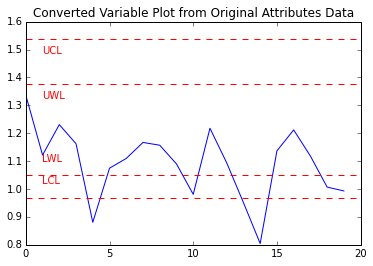

Reading negFlata.txt
[17.942, 20.486, 17.487, 19.306, 18.117, 17.651, 17.958, 19.197, 20.347, 19.768, 22.128, 19.509, 16.965, 20.019, 20.143, 20.633, 21.0, 22.556, 18.904, 20.522] [18.839, 24.273, 19.485, 17.181, 23.54, 20.651, 17.762, 21.241, 22.54, 18.208, 20.27, 19.722, 17.673, 22.367, 19.969, 21.072, 18.567, 18.689, 20.629, 20.214]
no change
No Change detected using Shewart method


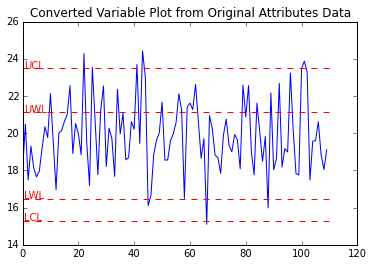

No Change detected using CUSUM method
No change detected using KS method
Reading negFlatb.txt
[17.942, 20.486, 17.487, 19.306, 18.117, 17.651, 17.958, 19.197, 20.347, 19.768, 22.128, 19.509, 16.965, 20.019, 20.143, 20.633, 21.0, 22.556, 18.904, 20.522] [18.839, 24.273, 19.485, 17.181, 23.54, 20.651, 17.762, 21.241, 22.54, 18.208, 20.27, 19.722, 17.673, 22.367, 19.969, 21.072, 18.567, 18.689, 20.629, 20.214]
no change
No Change detected using Shewart method


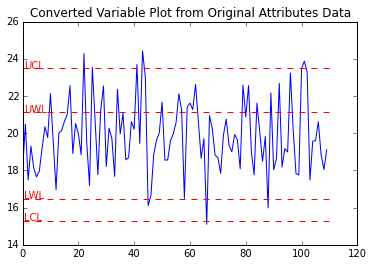

No Change detected using CUSUM method
No change detected using KS method
Reading negTriple.txt
No Change detected using Shewart method


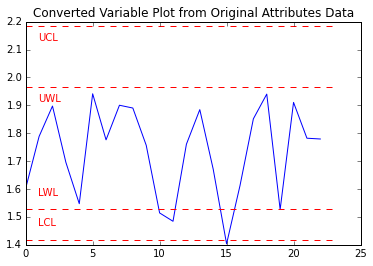

Reading negWithRare.txt
No Change detected using Shewart method


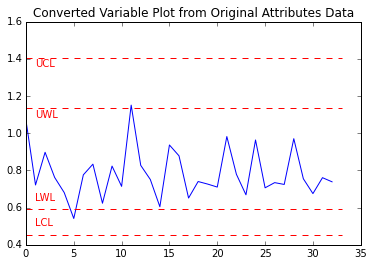

Reading posBinary_150.txt


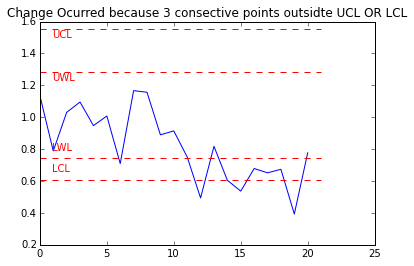

Concept change occured at position 192of original attributes data
Reading posShiftDownMean_90.txt
[86.446, 81.853, 72.082, 90.717, 82.316, 91.831, 89.104, 74.527, 69.665, 79.417, 77.355, 73.251, 83.982, 91.908, 75.628, 73.226, 78.029, 85.304, 73.166, 70.389] [79.478, 83.882, 75.236, 78.803, 76.522, 79.365, 92.281, 75.148, 69.221, 83.755, 72.771, 80.287, 74.98, 84.283, 84.423, 78.37, 63.565, 81.06, 92.744, 88.147]
Mean change gets smaller at position 81
79.28165 47.13485
Reading posShiftUpMean_70.txt
[57.405, 50.006, 60.752, 61.726, 53.121, 67.145, 67.135, 59.774, 61.964, 61.048, 58.88, 64.355, 56.47, 73.099, 59.182, 60.684, 66.401, 60.356, 59.426, 55.006] [51.983, 64.286, 69.741, 55.849, 65.148, 67.524, 50.438, 51.354, 63.427, 57.601, 64.14, 64.894, 64.271, 67.741, 64.012, 67.145, 52.785, 59.881, 59.06, 50.375]
Mean change gets larger at position 56
59.24685 75.7677
Reading posShiftUpVar_60.txt
[11.882, 81.127, 49.747, 70.979, 104.571, 69.282, 18.517, 80.08, 43.324, 17.351, 133.763, 53

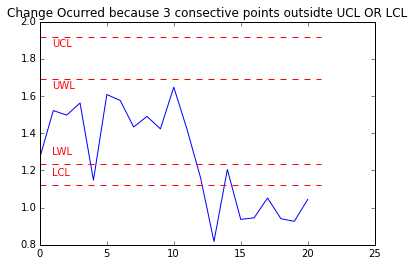

Concept change occured at position 156of original attributes data
Reading posTripleDouble_175.txt


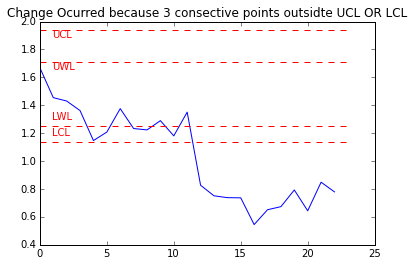

Concept change occured at position 132of original attributes data
Reading posTriple_175.txt


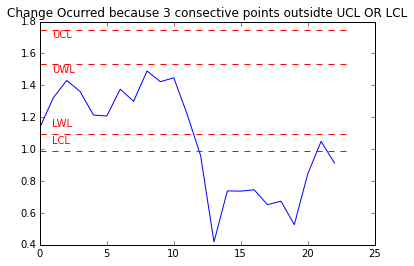

Concept change occured at position 132of original attributes data
['negBinary.txt', -1, 'negFlata.txt', -1, 'negFlatb.txt', -1, 'negTriple.txt', -1, 'negWithRare.txt', -1, 'posBinary_150.txt', 192, 'posShiftDownMean_90.txt', 81, 'posShiftUpMean_70.txt', 56, 'posShiftUpVar_60.txt', 56, 'posShiftUpVar_70.txt', 68, 'posTriple2_160.txt', 156, 'posTripleDouble_175.txt', 132, 'posTriple_175.txt', 132]


In [51]:
import os
shiftDetect(os.getcwd())